# Demo Image Classification

In this notebook I use the Hymenoptera dataset, which contains two classes of insects, for a binary classification problem. The code below shows how to train a ResNet model to classify images of Ants and Bees which are present in the dataset.

---
**Author:** Cisco Zabala

- Twitter:  [`@datasith`](https://twitter.com/datasith)
- LinkedIn: [`/in/datasith`](https://www.linkedin.com/in/datasith/)
- GitHub:   [`@datasith`](https://www.linkedin.com/in/datasith/)
- Kaggle:   [`@thedatasith`](https://www.linkedin.com/in/datasith/)

\**If you like my work, feel encouraged to follow me and contact me with any questions. Happy Kaggling!*

### Step 1: Include libraries

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import lr_scheduler, SGD
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
device

device(type='cuda')

### Step 2: Prepare the data (Kaggle dataset)

Given that this dataset is hosted on Kaggle, there's no need for preparing the data as it's readily accessible under `kaggle/input`.

In [2]:
!ls data/hymenoptera_data

train  val


In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)
                                ]),
    'val':   transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)
                                ]),
}

In [5]:
# import data
# data_dir = 'data/hymenoptera_data'
data_dir = 'data/dental-images'
sets = ['train', 'val']

dataset = {
            x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                    transform=data_transforms[x]) 
                                    for x in sets
           }

In [16]:
dataset

{'train': Dataset ImageFolder
     Number of datapoints: 379
     Root location: data/dental-images/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 95
     Root location: data/dental-images/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
            )}

In [6]:
classes = dataset['train'].classes
sizes = {x: len(dataset[x]) for x in sets}
classes

['over_18', 'under_18']

In [7]:
# define hyper parameters
num_classes   = len( classes )
num_epochs    = 10
batch_size    = 4
learning_rate = 0.001

In [8]:
dataloaders = {
               x: DataLoader(dataset[x], batch_size=batch_size, shuffle=True, num_workers=0)
                             for x in sets
              }

In [9]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fe5d8309240>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fe5d83091e0>}

In [10]:
examples = iter(dataloaders['train'])
samples, labels = next(examples)

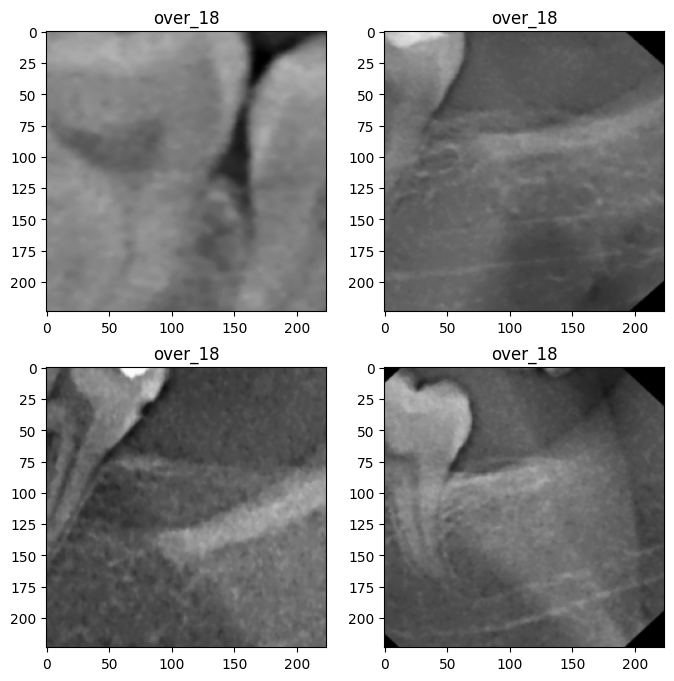

In [11]:
plt.figure(figsize=(8,8))
for i in range(batch_size):
    plt.subplot(2,2,i+1)
    img = samples[i].numpy().transpose((1, 2, 0))
    img = img*std + mean # de-normalize
    plt.imshow(img)
    plt.title(classes[ labels[i] ])
plt.show()

### Step 3-a: Train the model from scratch

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred_val, pred_idx = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred_idx == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / sizes[phase]
            epoch_accuracy = running_corrects.double() / sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_accuracy:.4f}')

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model

### Step 3-b: Train the model using Transfer Learning

In [13]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_features, len(class_names)).
model.fc = nn.Linear(num_features, 2)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

/home/antonjaragon/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/antonjaragon/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25
----------
train Loss: 0.7070 Acc: 0.5831
val Loss: 0.6560 Acc: 0.6316

Epoch 2/25
----------
train Loss: 0.6749 Acc: 0.6306
val Loss: 0.6626 Acc: 0.6632

Epoch 3/25
----------
train Loss: 0.6835 Acc: 0.5778
val Loss: 0.6736 Acc: 0.6421

Epoch 4/25
----------
train Loss: 0.6524 Acc: 0.5963
val Loss: 0.5963 Acc: 0.7263

Epoch 5/25
----------
train Loss: 0.6510 Acc: 0.6201
val Loss: 0.5943 Acc: 0.6842

Epoch 6/25
----------
train Loss: 0.6320 Acc: 0.6596
val Loss: 0.5992 Acc: 0.6947

Epoch 7/25
----------
train Loss: 0.6378 Acc: 0.6623
val Loss: 0.5746 Acc: 0.6842

Epoch 8/25
----------
train Loss: 0.6288 Acc: 0.6517
val Loss: 0.5850 Acc: 0.6737

Epoch 9/25
----------
train Loss: 0.6112 Acc: 0.6728
val Loss: 0.5707 Acc: 0.6842

Epoch 10/25
----------
train Loss: 0.6108 Acc: 0.6675
val Loss: 0.5751 Acc: 0.6842

Epoch 11/25
----------
train Loss: 0.6316 Acc: 0.6570
val Loss: 0.5742 Acc: 0.6737

Epoch 12/25
----------
train Loss: 0.6131 Acc: 0.6491
val Loss: 0.5794 Acc: 0.6947

E

In [14]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.8248 Acc: 0.5726
val Loss: 0.7202 Acc: 0.6211

Epoch 2/25
----------
train Loss: 0.9029 Acc: 0.5646
val Loss: 0.8454 Acc: 0.6421

Epoch 3/25
----------
train Loss: 0.7797 Acc: 0.5858
val Loss: 1.0369 Acc: 0.4526

Epoch 4/25
----------
train Loss: 0.8147 Acc: 0.5541
val Loss: 0.6775 Acc: 0.6421

Epoch 5/25
----------
train Loss: 0.6708 Acc: 0.6491
val Loss: 0.9156 Acc: 0.5368

Epoch 6/25
----------
train Loss: 0.7196 Acc: 0.6174
val Loss: 0.8805 Acc: 0.5789

Epoch 7/25
----------
train Loss: 0.9265 Acc: 0.6016
val Loss: 1.4311 Acc: 0.6421

Epoch 8/25
----------
train Loss: 0.7917 Acc: 0.6121
val Loss: 0.6710 Acc: 0.6526

Epoch 9/25
----------
train Loss: 0.6640 Acc: 0.6306
val Loss: 0.6629 Acc: 0.6421

Epoch 10/25
----------
train Loss: 0.6649 Acc: 0.6280
val Loss: 0.6438 Acc: 0.6316

Epoch 11/25
----------
train Loss: 0.6396 Acc: 0.6385
val Loss: 0.6488 Acc: 0.6632

Epoch 12/25
----------
train Loss: 0.6644 Acc: 0.6201
val Loss: 0.6523 Acc: 0.6316

E

### Acnowledgements

This Notebook integrates the wonderful tutorial by "Python Engineer" to the Kaggle ecosystem:
https://www.youtube.com/watch?v=c36lUUr864M